In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D,MaxPool2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.layers import BatchNormalization
import tensorflow as tf
import os

In [ ]:
!unzip "/content/drive/MyDrive/RESEARCH CANCER/data_merged.zip"

Streaming output truncated to the last 5000 lines.
  inflating: content/MERGED_DATA/train/nevus/ISIC_0029214.jpg  
  inflating: content/MERGED_DATA/train/nevus/ISIC_0032627.jpg  
  inflating: content/MERGED_DATA/train/nevus/ISIC_0031279.jpg  
  inflating: content/MERGED_DATA/train/nevus/ISIC_0026020.jpg  
  inflating: content/MERGED_DATA/train/nevus/ISIC_0032361.jpg  
  inflating: content/MERGED_DATA/train/nevus/ISIC_0026320.jpg  
  inflating: content/MERGED_DATA/train/nevus/ISIC_0026367.jpg  
  inflating: content/MERGED_DATA/train/nevus/ISIC_0028948.jpg  
  inflating: content/MERGED_DATA/train/nevus/ISIC_0000387.jpg  
  inflating: content/MERGED_DATA/train/nevus/ISIC_0028768.jpg  
  inflating: content/MERGED_DATA/train/nevus/ISIC_0029785.jpg  
  inflating: content/MERGED_DATA/train/nevus/ISIC_0025172.jpg  
  inflating: content/MERGED_DATA/train/nevus/ISIC_0031466.jpg  
  inflating: content/MERGED_DATA/train/nevus/ISIC_0024468.jpg  
  inflating: content/MERGED_DATA/train/nevus/ISIC_003

In [ ]:
train_data_dir="/content/content/MERGED_DATA/train"
arr1=[]
for _ in os.listdir(train_data_dir):
  arr1.append(_)
  


In [ ]:
DATADIR='/content/content/MERGED_DATA/train'
CATEGORIES=arr1
DATADIR1="/content/content/MERGED_DATA/val"

In [ ]:

import os
import math 

files={}
dir='/content/content/MERGED_DATA/train'
a=0
mul={}
arr1=[]
temp_1=[]
path = dir 
for _ in os.listdir(path):
  
  temp_1.append(_)
  x=os.path.join(path,_)
  z = os.listdir(x) 
  number_files = len(z)
  #number_files = len(list)
  
  print(_+' '+str(number_files))
  



  

dermatofibroma 80
vascular lesion 99
actinic keratosis 228
squamous cell carcinoma 126
pigmented benign keratosis 769
nevus 4943
basal cell carcinoma 359
seborrheic keratosis 53
melanoma 1085


In [ ]:

import os
import math 

files={}
dir='/content/content/MERGED_DATA/val'
a=0
mul={}
arr1=[]
path = dir 
for _ in os.listdir(path):
  
  
  x=os.path.join(path,_)
  z = os.listdir(x) 
  number_files = len(z)
  #number_files = len(list)
  
  print(_+' '+str(number_files))
  



  

dermatofibroma 23
vascular lesion 28
actinic keratosis 65
squamous cell carcinoma 36
pigmented benign keratosis 219
nevus 1412
basal cell carcinoma 102
seborrheic keratosis 15
melanoma 310


In [ ]:
!pip install -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 901kB 13.8MB/s 
     |████████████████████████████████| 3.3MB 50.4MB/s 


In [ ]:
import torchvision
from torchvision.transforms import ToTensor

train_ds = torchvision.datasets.ImageFolder('/content/content/MERGED_DATA/test', transform=ToTensor())
valid_ds = torchvision.datasets.ImageFolder('/content/content/MERGED_DATA/test', transform=ToTensor())
test_ds = torchvision.datasets.ImageFolder('/content/content/MERGED_DATA/test', transform=ToTensor())

In [ ]:
from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F

class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=3):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        if loss is not None:
          return logits, loss.item()
        else:
          return logits, None

In [ ]:
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 2e-5

In [ ]:
from transformers import ViTFeatureExtractor
import torch.nn as nn
import torch
# Define Model
model = ViTForImageClassification(len(train_ds.classes))    
# Feature Extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()
# Use GPU if available  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
if torch.cuda.is_available():
    model.cuda() 

In [ ]:
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np

print("Number of train samples: ", len(train_ds))
print("Number of test samples: ", len(test_ds))
print("Detected Classes are: ", train_ds.class_to_idx) 

train_loader = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
test_loader  = data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4) 

# Train the model
for epoch in range(EPOCHS):        
  for step, (x, y) in enumerate(train_loader):
    # Change input array into list with each batch being one element
    x = np.split(np.squeeze(np.array(x)), BATCH_SIZE)
    # Remove unecessary dimension
    for index, array in enumerate(x):
      x[index] = np.squeeze(array)
    # Apply feature extractor, stack back into 1 tensor and then convert to tensor
    x = torch.tensor(np.stack(feature_extractor(x)['pixel_values'], axis=0))
    # Send to GPU if available
    x, y  = x.to(device), y.to(device)
    b_x = Variable(x)   # batch x (image)
    b_y = Variable(y)   # batch y (target)
    # Feed through model
    output, loss = model(b_x, None)
    # Calculate loss
    if loss is None: 
      loss = loss_func(output, b_y)   
      optimizer.zero_grad()           
      loss.backward()                 
      optimizer.step()

    if step % 50 == 0:
      # Get the next batch for testing purposes
      test = next(iter(test_loader))
      test_x = test[0]
      # Reshape and get feature matrices as needed
      test_x = np.split(np.squeeze(np.array(test_x)), BATCH_SIZE)
      for index, array in enumerate(test_x):
        test_x[index] = np.squeeze(array)
      test_x = torch.tensor(np.stack(feature_extractor(test_x)['pixel_values'], axis=0))
      # Send to appropirate computing device
      test_x = test_x.to(device)
      test_y = test[1].to(device)
      # Get output (+ respective class) and compare to target
      test_output, loss = model(test_x, test_y)
      test_output = test_output.argmax(1)
      # Calculate Accuracy
      accuracy = (test_output == test_y).sum().item() / BATCH_SIZE
      print('Epoch: ', epoch, '| train loss: %.4f' % loss, '| test accuracy: %.2f' % accuracy)

Epoch 1/100
156/156 [==============================] - 21s 64ms/step - loss: 1.4524 - accuracy: 0.6281 - val_loss: 0.9730 - val_accuracy: 0.6738
Epoch 2/100
156/156 [==============================] - 8s 54ms/step - loss: 0.8812 - accuracy: 0.7030 - val_loss: 0.7907 - val_accuracy: 0.7273
Epoch 3/100
156/156 [==============================] - 9s 55ms/step - loss: 0.7970 - accuracy: 0.7210 - val_loss: 0.6663 - val_accuracy: 0.7669
Epoch 4/100
156/156 [==============================] - 8s 54ms/step - loss: 0.7231 - accuracy: 0.7422 - val_loss: 0.6201 - val_accuracy: 0.7697
Epoch 5/100
156/156 [==============================] - 6s 39ms/step - loss: 0.6746 - accuracy: 0.7580 - val_loss: 0.5739 - val_accuracy: 0.8045
Epoch 6/100
156/156 [==============================] - 6s 39ms/step - loss: 0.6247 - accuracy: 0.7764 - val_loss: 0.5477 - val_accuracy: 0.8086
Epoch 7/100
156/156 [==============================] - 6s 39ms/step - loss: 0.5781 - accuracy: 0.7959 - val_loss: 0.5020 - val_accuracy

In [ ]:
y_pred=model.predict(test_x)

63/63 [==============================] - 1s 14ms/step


In [ ]:
from sklearn.metrics import classification_report
y_true=test_y
y_pred = tf.argmax(y_pred, axis=1)



In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        28
           2       0.71      0.42      0.52        65
           3       0.54      0.81      0.64        36
           4       1.00      1.00      1.00       219
           5       0.99      1.00      0.99      1412
           6       1.00      1.00      1.00       102
           7       1.00      0.40      0.57        15
           8       0.91      1.00      0.95       100

    accuracy                           0.97      2000
   macro avg       0.91      0.85      0.85      2000
weighted avg       0.97      0.97      0.97      2000



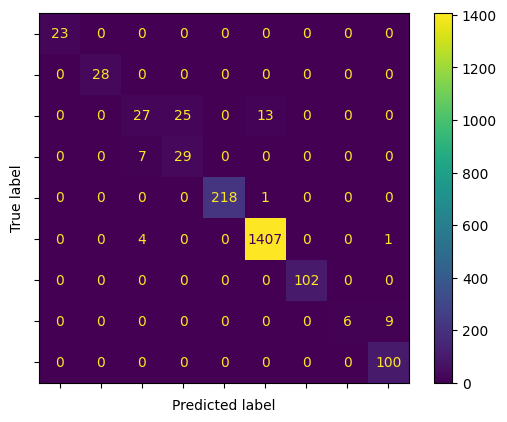

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
conf_mat = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = arr1)

cm_display.plot()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc



# Make predictions on the test data
y_pred_prob = model.predict(test_x)

# Convert predicted probabilities to binary predictions
y_pred = np.argmax(y_pred_prob, axis=1)

# Get actual labels of the test data
y_true = test_y

#


63/63 [==============================] - 1s 14ms/step


In [ ]:
print(y_pred)

[0 0 0 ... 8 8 8]


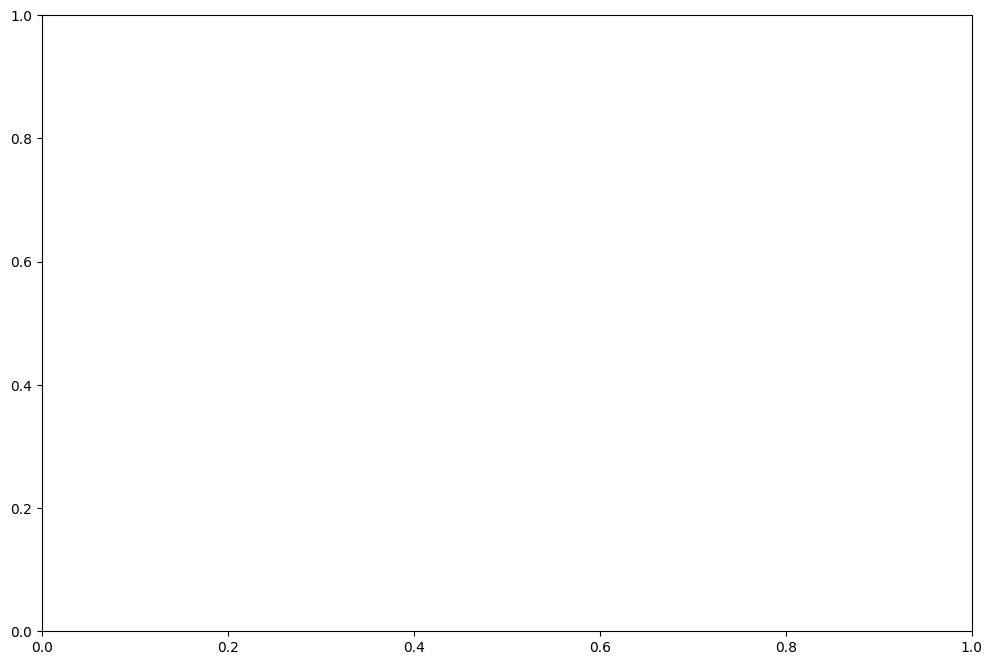

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= arr1





ROC AUC score: 0.9202970179969321


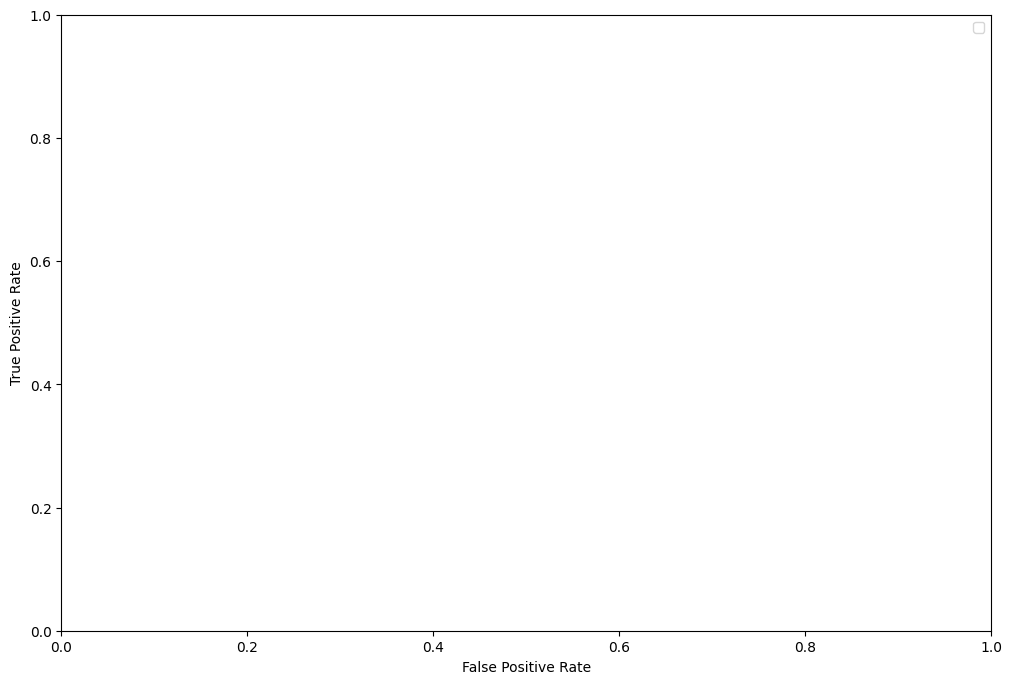

In [ ]:
# function for scoring roc auc score for multi-class
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    t=0
    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
        t=fpr
        c_ax.plot(t, t, 'b-', label = arr1[idx])
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_true, y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [ ]:
print('hello')